In [1]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
cfg.data.sdoml.sub_directory.eve

'EVE_legacy.zarr"'

In [4]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 4,
    num_workers = 4,
    num_frames  = 1,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2011-01-01',
    end_date   = '2011-12-31',
    dim = True,
    sampling_period = '5days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(12, 64, 3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=2)
        self.fc1 = nn.Linear(12544, 768)
        self.fc2 = nn.Linear(768, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    
    
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(3,)
        self.pool2 = nn.AvgPool2d(2,)

        self.conv1 = nn.Conv2d(12, 64, 3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.fc1 = nn.Linear(93312, 12)

    def forward(self, x):
        x = self.pool2(x) # downscale img by 2 (to make it similar to paper)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

In [6]:
model = Net1()
psize = [np.prod(i.shape) for i in model.parameters()]
print (psize, sum(psize))


[6912, 64, 73728, 128, 294912, 256, 589824, 256, 9633792, 768, 64512, 84, 1008, 12] 10666256


In [7]:
x = torch.rand((4,12,512,512))
model(x).shape

torch.Size([4, 12])

In [40]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(7071, 586)

In [23]:
psize = [np.prod(i.shape) for i in model.parameters()]
print (psize, sum(psize))


[6912, 64, 73728, 128, 294912, 256, 589824, 256, 9633792, 768, 64512, 84, 1008, 12] 10666256


In [10]:
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

In [41]:
et = ElapsedTimes()
num_epochs = 100
lossh, lossvalh = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    for step, batch in enumerate(dltrain):
        # extract data from batch
        with et("batch"):
            x = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
            f = batch['dim_factor'].type(torch.float).cuda()

        # run model
        with et("forward"):
            o = model(x)

        # compute loss
        with et("loss"):
            loss = loss_fn(f,o)

        # backpropage and sigmoidupdate
        with et("backward"):
            loss.backward()
            optimizer.step()

        with et("validation"):

            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()

        with et("logging"):
            # cosmetics
            lossn = loss.detach().cpu().numpy()
            lossh.append(lossn)

            lossvalh.append(lossvaln)


            psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
            lossm = np.mean(lossh[-100:])
            lossvalm = np.mean(lossvalh[-100:])
            epoch_time = (datetime.now() - t0).seconds
            print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

    print()

epoch   0 step 7070 loss 0.57283 lossval 0.56533 params 4.8291025 epoch_time 1052 secs
epoch   1 step 7070 loss 0.57541 lossval 0.58726 params 4.8817859 epoch_time 1054 secs
epoch   2 step 7070 loss 0.57595 lossval 0.57375 params 4.9345927 epoch_time 1051 secs
epoch   3 step 7070 loss 0.57670 lossval 0.56714 params 4.9875345 epoch_time 1047 secs
epoch   4 step 7070 loss 0.57352 lossval 0.57895 params 5.0406003 epoch_time 1043 secs
epoch   5 step 7070 loss 0.57447 lossval 0.57669 params 5.0937953 epoch_time 1044 secs
epoch   6 step 7070 loss 0.56931 lossval 0.55688 params 5.1471777 epoch_time 1040 secs
epoch   7 step 7070 loss 0.57610 lossval 0.59429 params 5.2006612 epoch_time 1044 secs
epoch   8 step 7070 loss 0.57740 lossval 0.58256 params 5.2542572 epoch_time 1056 secs
epoch   9 step 7070 loss 0.57836 lossval 0.58421 params 5.3079562 epoch_time 1070 secs
epoch  10 step 7070 loss 0.57945 lossval 0.56333 params 5.3617511 epoch_time 1072 secs
epoch  11 step 7070 loss 0.57826 lossval 0.

KeyboardInterrupt: 

In [ ]:
epoch   0 step 928 loss 0.24618 lossval 0.25290 params 0.0281104 epoch_time 508 secs
epoch   1 step 928 loss 0.22471 lossval 0.22321 params 0.0310339 epoch_time 510 secs
epoch   2 step 928 loss 0.20881 lossval 0.21051 params 0.0348158 epoch_time 509 secs
epoch   3 step 928 loss 0.20030 lossval 0.19811 params 0.0396735 epoch_time 510 secs
epoch   4 step 928 loss 0.17994 lossval 0.18165 params 0.0447329 epoch_time 507 secs
epoch   5 step 928 loss 0.17655 lossval 0.17553 params 0.0501438 epoch_time 510 secs
epoch   6 step 928 loss 0.16218 lossval 0.16626 params 0.0559725 epoch_time 508 secs
epoch   7 step 536 loss 0.15901 lossval 0.16068 params 0.0596325 epoch_time 296 secs

In [ ]:
1

In [12]:
et

{'batch': 185.39516639709473, 'forward': 12.046120643615723, 'loss': 3.2611753940582275, 'backward': 21.528714179992676, 'validation': 63.49454307556152, 'logging': 390.5474045276642}

In [13]:
sum(list(et.elapsed_times.values()))

676.2731242179871

In [42]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

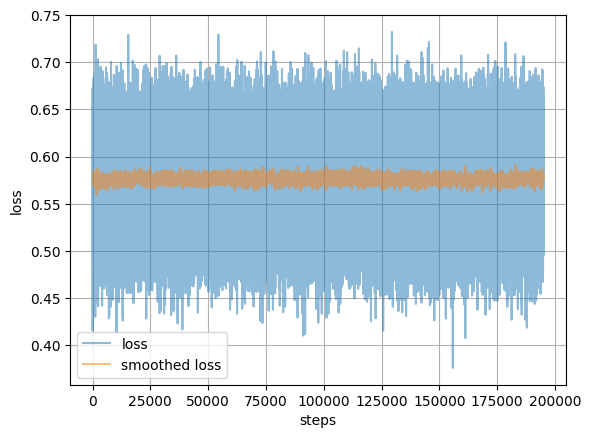

In [43]:
ploth(lossh)
#plt.ylim(0,.5)

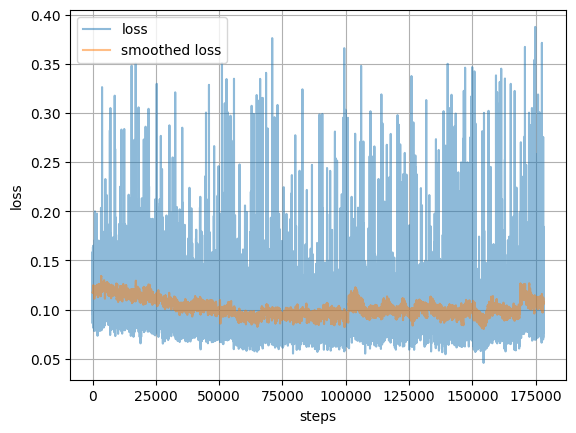

In [35]:
ploth(lossh)
#plt.ylim(0,.5)

(0.0, 0.5)

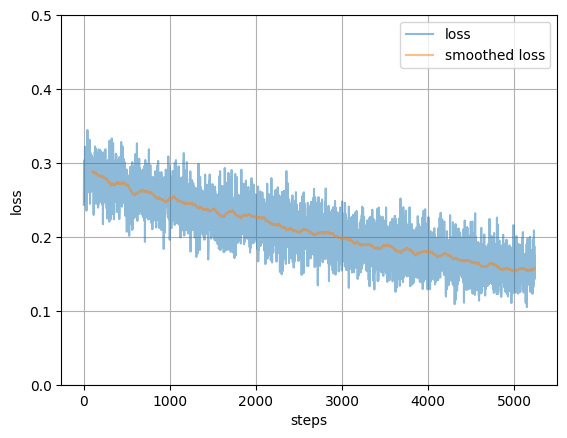

In [16]:
ploth(lossh)
plt.ylim(0,.5)